# Sensitivity Analysis

In [1]:
import os
import itertools
import random

import pandas as pd
import numpy as np
import scipy

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

import sys
sys.path.insert(0, '../utils')
import model_utils
import geoutils

import logging
import warnings
logging.getLogger().setLevel(logging.ERROR)
warnings.filterwarnings("ignore")

SEED = 42

%load_ext autoreload
%autoreload 2

## File Locations

In [2]:
lr_index, rf_index, svc_index = 7, 3, 3
output_dir = "../outputs/"
neg_samples_strs = ['10k', '30k', '50k']
neg_samples_dirs = [
    output_dir + '10k_results/',
    output_dir + '30k_results/',
    output_dir + '50k_results/'
]
model_types = [
    'logistic_regression', 
    'random_forest', 
    'linear_svc'
]

## Load Results

In [3]:
results_dict = model_utils.load_neg_sample_results(model_types, neg_samples_strs, neg_samples_dirs)
results_dict['logistic_regression']['10k_per_area'][0]['pixel_preds'][lr_index].head(3)

,grid_id,area,y_pred,y_test
0,62,0,0.000428,0
1,64,0,0.000722,0
2,60,0,0.000193,0


## Generate Sensitivity Analysis Matrix

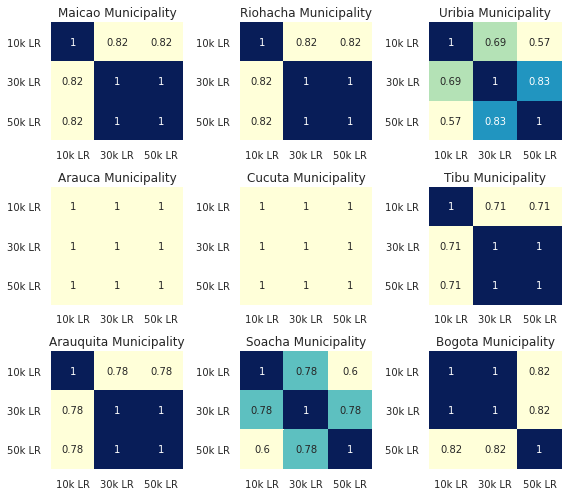

In [4]:
lr_area_dict = {
    '10k LR' : results_dict['logistic_regression']['10k_per_area'],
    '30k LR' : results_dict['logistic_regression']['30k_per_area'],
    '50k LR' : results_dict['logistic_regression']['50k_per_area'],
}
model_utils.generate_iou_matrix_per_area(
    lr_area_dict, lr_index, model_utils.AREA_CODES, percent=0.20
)

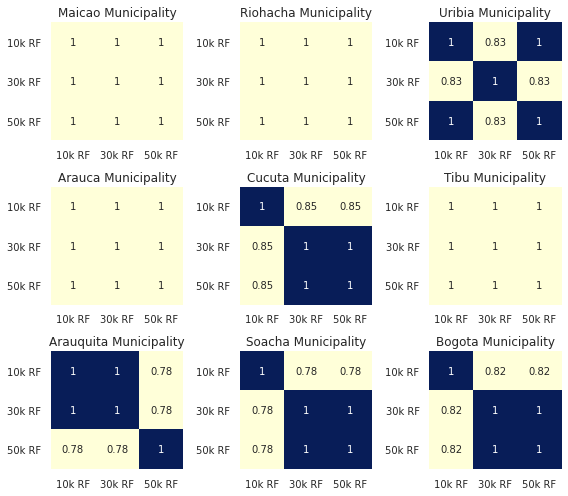

In [5]:
rf_area_dict = {
    '10k RF' : results_dict['random_forest']['10k_per_area'],
    '30k RF' : results_dict['random_forest']['30k_per_area'],
    '50k RF' : results_dict['random_forest']['50k_per_area'],
}
model_utils.generate_iou_matrix_per_area(
    rf_area_dict, rf_index, model_utils.AREA_CODES, percent=0.20
)

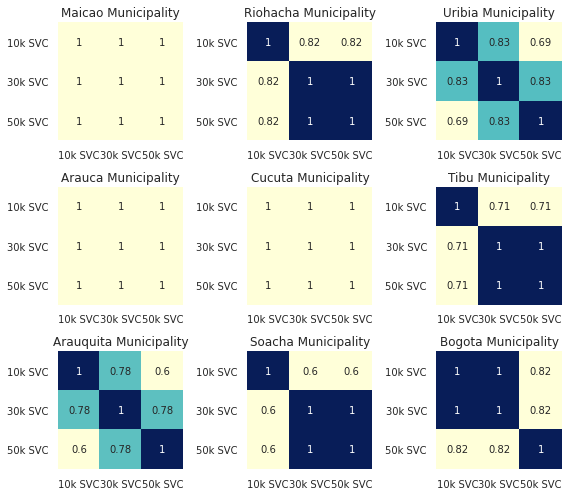

In [6]:
svc_area_dict = {
    '10k SVC' : results_dict['linear_svc']['10k_per_area'],
    '30k SVC' : results_dict['linear_svc']['30k_per_area'],
    '50k SVC' : results_dict['linear_svc']['50k_per_area'],
}
model_utils.generate_iou_matrix_per_area(
    svc_area_dict, svc_index, model_utils.AREA_CODES, percent=0.20
)

## Sensitivity Analysis on Unseen Test Set

In [7]:
from tqdm import tqdm
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    MinMaxScaler,
    StandardScaler
)
SEED = 42

### File Locations

In [8]:
version = '20200509'
data_dir = "../data/"

input_file = data_dir + '{}_dataset.csv'.format(version)
output_dir = "../outputs/sensitivity/"
tmp_dir = data_dir + 'tmp/'

images_dir = data_dir + 'images/'
indices_dir = data_dir + 'indices/'

if not os.path.exists(output_dir):
    os.makedirs(output_dir)
if not os.path.exists(tmp_dir):
    os.makedirs(tmp_dir)

In [9]:
#!gsutil -q -m cp gs://immap-images/20200525/medellin_*.tif {images_dir}
#!gsutil -q -m cp gs://immap-indices/20200525/indices_medellin_*.tif {indices_dir}
#!gsutil -q -m cp gs://immap-images/20200518/cali_*.tif {images_dir}
#!gsutil -q -m cp gs://immap-indices/20200518/indices_cali_*.tif {indices_dir}
#!gsutil -q -m cp gs://immap-images/20200508/malambo_*.tif {images_dir}
#!gsutil -q -m cp gs://immap-indices/20200508/indices_malambo_*.tif {indices_dir}

### Load Data

In [10]:
raw_data = pd.read_csv(input_file).reset_index(drop=True)
print('Data dimensions: {}'.format(raw_data.shape))
raw_data.head(3)

Data dimensions: (1029869, 69)


,B1_2015-2016,B2_2015-2016,B3_2015-2016,B4_2015-2016,B5_2015-2016,B6_2015-2016,B7_2015-2016,B8_2015-2016,B9_2015-2016,B10_2015-2016,...,mndwi_2019-2020,ui_2019-2020,nbi_2019-2020,brba_2019-2020,nbai_2019-2020,mbi_2019-2020,baei_2019-2020,target,uid,area
0,0.15100,0.13225,0.14240,0.16430,0.1899,0.25700,0.2960,0.25510,0.32295,0.0396,...,-0.438625,0.151655,0.209614,0.479385,-0.665204,-0.060444,0.948025,3,39,0
1,0.15100,0.12885,0.13790,0.16185,0.1899,0.25700,0.2960,0.25755,0.32295,0.0396,...,-0.435450,0.151655,0.213526,0.488330,-0.663010,-0.059064,0.952352,3,39,0
2,0.15895,0.13730,0.15185,0.18915,0.2264,0.28555,0.3268,0.28085,0.35740,0.0416,...,-0.447333,0.145385,0.222971,0.473118,-0.661291,-0.060496,0.911748,3,39,0


### Check Hyperparameters of Best Model

In [11]:
print('Logistic Regression Parameters: {}'.format(
    results_dict['logistic_regression']['30k']['labels'][lr_index]
))
print('Random Forest Parameters: {}'.format(
    results_dict['random_forest']['30k']['labels'][rf_index]
))

Logistic Regression Parameters: penalty=l1, C=1.000
Random Forest Parameters: n_estimators=800, max_depth=12, min_samples_split=15, min_samples_leaf=2


### Instantiate Models

In [14]:
lr = LogisticRegression(penalty='l1', C=1.0)
rf = RandomForestClassifier(
    n_estimators=800, 
    max_depth=12, 
    min_samples_split=15,
    min_samples_leaf=2,
    random_state=42
)

neg_samples_list = [10000, 30000, 50000]
models, model_strs = [lr, rf], ['LR', 'RF']
areas = ['medellin', 'cali', 'malambo']
area_dict = geoutils.get_filepaths(areas, images_dir, indices_dir)

### Run Model for 10k, 30k, and 50k Negative Samples

In [15]:
for num_neg_samples, neg_samples_str in zip(neg_samples_list, neg_samples_strs):
    for model, model_str in zip(models, model_strs):
        model, features = model_utils.train_model(model, raw_data, num_neg_samples, SEED)
        for area in areas:
            output = output_dir + '{}_{}_{}_{}.tif'.format(version, area, model_str, neg_samples_str)
            geoutils.get_preds_windowing(
                area=area, 
                area_dict=area_dict,
                model=model, 
                tmp_dir=tmp_dir,
                best_features=features,  
                output=output, 
                grid_blocks=9,
                threshold=0
            )

100%|██████████| 81/81 [01:49<00:00,  1.35s/it]


In [18]:
for file in os.listdir(output_dir):
    if '.ipynb' not in file:
        out_file = output_dir + file
        !gsutil -q cp {out_file} gs://immap-results/probmaps/